In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
    print(repo_path)
    
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None
exp_path = Path.cwd().resolve() # path to the experiment folder

print(f"Repo Path: {repo_path}")
print(f"Experiment Path: {exp_path}")

#Libraries
import yaml
import math
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    ToTensor,
    Normalize,
    InterpolationMode,
)
import wandb
import datasets, diffusers
from diffusers import (
    UNet2DModel,
    DDPMScheduler,
)   
from diffusers import DDPMPipeline
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
from diffusers.utils.import_utils import is_xformers_available
import logging
from accelerate.logging import get_logger
from accelerate import Accelerator

# extra
from packaging import version

# import the MRIDataset class from the dataset folder
from dataset.build_dataset import MRIDataset

/home/benet/tfg/experiments
/home/benet/tfg
Repo Path: /home/benet/tfg
Experiment Path: /home/benet/tfg/experiments/latent


In [2]:
### 0. General setup
# load the config file
config_path = exp_path / 'config_latent.yaml' # configuration file path (beter to call it from the args parser)
with open(config_path) as file: # expects the config file to be in the same directory
    config = yaml.load(file, Loader=yaml.FullLoader)


In [4]:
### 1. Dataset loading and preprocessing
# Dataset loading
data_dir = repo_path / config['processing']['dataset']
print(f"Data directory: {data_dir}")    
# Define the transformations to apply to the images
preprocess = Compose(
    [
        # Resize(config['processing']['resolution'], interpolation= InterpolationMode.BILINEAR), #getattr(InterpolationMode, config['processing']['interpolation'])),  # Smaller edge is resized to 256 preserving aspect ratio
        # CenterCrop(config['processing']['resolution']),  # Center crop to the desired squared resolution
        #RandomHorizontalFlip(),  # Horizontal flip may not be a good idea if we want generation only one laterality
        ToTensor(),  # Convert to PyTorch tensor
        # Normalize(mean=[0.5], std=[0.5]),  # Map to (-1, 1) as a way to make data more similar to a Gaussian distribution
    ]
)

# Create dataset with the defined transformations
dataset = MRIDataset(data_dir, transform=preprocess, latents=True) # create the dataset
# Create the dataloader
train_dataloader = DataLoader(
    dataset, batch_size=config['processing']['batch_size'], num_workers= config['processing']['num_workers'], shuffle=True
)

Data directory: /home/benet/data/VH2D/latent_flair


In [7]:
from diffusers import DDPMPipeline, AutoencoderKL

# Load the VAE model
vae = AutoencoderKL.from_pretrained(repo_path / config['saving']['local']['outputs_dir'] / config['saving']['local']['vae_name'])
vae.eval() # set the model to evaluation mode

# decode the latents
for latents in train_dataloader:
    print(latents.shape)
    print(latents[0].shape)
    decoded = vae.decode(latents).sample  # Add batch dim
    
    break

torch.Size([4, 4, 32, 32])
torch.Size([4, 32, 32])


torch.Size([4, 3, 256, 256])


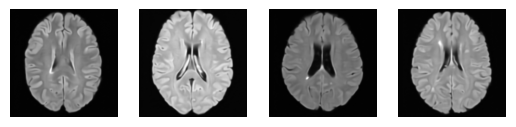

In [10]:
print(decoded.shape)
# plot
import matplotlib.pyplot as plt

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(decoded[i][0].squeeze().detach().numpy(), cmap="gray")
    plt.axis("off")
plt.show()

In [49]:
decoded = vae.decode(latents).sample # Add batch dim

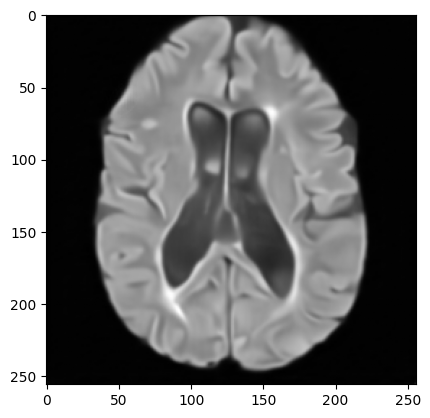

In [19]:
import matplotlib.pyplot as plt

plt.imshow(decoded[0][0].detach().cpu().numpy(), cmap='gray')